In [224]:
import torch
import os
import torch.nn as nn
import pandas as pd
import numpy as np      
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve


In [225]:
# import dataset
df = pd.read_csv("../3 - Cleaning & Transforming Data/1 cleaned_dataset_MERGED_DRUG(Mogran).csv", index_col = None)

if(df.isna().any().sum()) != 0:
    raise Exception('There are still missing values in the dataset!')

In [226]:
df

,Drug,Allele,ADR_MPeruption,ADR_MPexanthema,ADR_SJS,ADR_TEN,ADR,Cohort ethnicity_Black,Cohort ethnicity_Caucasian,Cohort ethnicity_Diverse,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,carbamazepine,B*15:02,0,0,0,1,TEN,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,carbamazepine,B*15:02,0,0,0,1,TEN,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,carbamazepine,B*15:02,0,0,0,1,TEN,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,carbamazepine,B*15:02,0,0,0,1,TEN,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,carbamazepine,B*15:02,0,0,0,1,TEN,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15966,oxcarbazepine,A*31:01,0,0,0,0,MPexanthema,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15967,oxcarbazepine,A*31:01,0,0,0,0,MPexanthema,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15968,oxcarbazepine,A*31:01,0,0,0,0,MPexanthema,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15969,oxcarbazepine,A*31:01,0,0,0,0,MPexanthema,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [227]:
df2 = pd.read_csv("../3 - Cleaning & Transforming Data/0 alleles_seq_embedded.csv", index_col = None)

In [228]:
df_merged = pd.merge(df, df2, left_on='Allele', right_on='new_alleles', how='inner')

In [229]:
df['ADR'].value_counts()

SJS            7059
TEN            4692
MPexanthema    2435
MPeruption     1785
Name: ADR, dtype: int64

In [230]:
for x in df_merged.columns:
    print(x)

Drug
Allele
ADR_MPeruption
ADR_MPexanthema
ADR_SJS
ADR_TEN
ADR
Cohort ethnicity_Black
Cohort ethnicity_Caucasian
Cohort ethnicity_Diverse
Cohort ethnicity_Mongol
Cohort ethnicity
No_ADR
Yes_ADR
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228


In [231]:
# Drop unnecessary columns
df_stratify = pd.DataFrame()
df_merged['ADR'] = df_merged['ADR'].replace({'SJS': 0, 'TEN': 1, 'MPexanthema':2,'MPeruption':3})
#df_merged = df_merged[df_merged['ADR'].isin([0,1])] #ลบ MP ออก
df_stratify['ADR'] = df_merged['ADR'].copy()
df_merged.drop(columns=['No_ADR','ADR','ADR_MPeruption','ADR_MPexanthema','ADR_SJS','ADR_TEN','Cohort ethnicity','Allele','Drug','new_alleles','Sequence_prot1','Sequence_prot2','Sequence_prot1_Char','Sequence_prot2_Char'], inplace=True)


In [232]:
for x in df_merged.columns:
    print(x)

Cohort ethnicity_Black
Cohort ethnicity_Caucasian
Cohort ethnicity_Diverse
Cohort ethnicity_Mongol
Yes_ADR
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250

In [233]:
#df = df[df['ADR'].isin([1,2])] 

In [234]:
df_stratify['ADR'].value_counts()

0    5805
1    3738
2    1896
3    1634
Name: ADR, dtype: int64

In [235]:
df.dtypes

Drug               object
Allele             object
ADR_MPeruption      int64
ADR_MPexanthema     int64
ADR_SJS             int64
                    ...  
2043                int64
2044                int64
2045                int64
2046                int64
2047                int64
Length: 2062, dtype: object

In [236]:
# Select output columns and drop unnecessary columns
df_output = df_merged['Yes_ADR'].copy()
df_merged.drop(columns = ['Yes_ADR'], inplace = True)
df_input = df_merged.copy()
# Check input dtypes
df_input.dtypes.value_counts()

int64    2149
dtype: int64

In [237]:
df_input

,Cohort ethnicity_Black,Cohort ethnicity_Caucasian,Cohort ethnicity_Diverse,Cohort ethnicity_Mongol,0,1,2,3,4,5,...,p45_1,p46_1,p47_1,p48_1,p49_1,p50_1,p51_1,p52_1,p53_1,p54_1
0,0,0,1,0,0,0,0,0,0,0,...,0,0,10,4,12,6,9,4,17,10
1,0,0,1,0,0,0,0,0,0,0,...,0,0,10,4,12,6,9,4,17,10
2,0,0,1,0,0,0,0,0,0,0,...,0,0,10,4,12,6,9,4,17,10
3,0,0,0,1,0,0,0,0,0,0,...,0,0,10,4,12,6,9,4,17,10
4,0,0,0,1,0,0,0,0,0,0,...,0,0,10,4,12,6,9,4,17,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,0,0,0,1,0,0,0,0,0,0,...,0,0,10,4,12,6,9,4,17,10
13069,0,0,0,1,0,0,0,0,0,0,...,0,0,10,4,12,6,9,4,17,10
13070,0,0,0,1,0,0,0,0,0,0,...,0,0,10,4,12,6,9,4,17,10
13071,0,0,0,1,0,0,0,0,0,0,...,0,0,10,4,12,6,9,4,17,10


In [238]:
df_output

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
13068    0.0
13069    0.0
13070    0.0
13071    0.0
13072    0.0
Name: Yes_ADR, Length: 13073, dtype: float64

In [239]:
df_stratify

,ADR
0,1
1,1
2,1
3,1
4,1
...,...
13068,2
13069,2
13070,2
13071,2


In [240]:
# # Change all input dtypes to float64
# df_input = df_input.astype('float64')
# df_input.dtypes.value_counts()

In [241]:
# Convert to numpy array
np_input = df_input.to_numpy()
np_output = df_output.to_numpy()
np_stratify = df_stratify.to_numpy()

In [242]:
np_input

array([[ 0,  0,  1, ...,  4, 17, 10],
       [ 0,  0,  1, ...,  4, 17, 10],
       [ 0,  0,  1, ...,  4, 17, 10],
       ...,
       [ 0,  0,  0, ...,  4, 17, 10],
       [ 0,  0,  0, ...,  4, 17, 10],
       [ 0,  0,  0, ...,  4, 17, 10]], dtype=int64)

In [243]:
def get_dataloaders(batch_size):

    # Train Test Splits
    X_train, X_test, y_train, y_test = train_test_split(np_input, np_output, test_size = 0.2, random_state = 128, stratify = np_stratify, shuffle = True)

    # See Distribution
    print('BEFORE applying weight train_label data distribution 0/1: {}/{}'.format(
    len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))

    print('BEFORE applying weight test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0])))

    # Find Weight of each class in train_labels
    weight = (1/pd.DataFrame(y_train).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in y_train])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

    # Create TensorDataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,drop_last=True)

    return train_loader, test_loader

In [244]:
# Function to check dataloader classes distribution
def get_dataloader_distribution(*args):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(target.numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])

        X_axis = np.arange(len(batch_count))

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis,class_0_count,width=(1/3) ,label = "NoADR",color='green',alpha=0.5)
        ax[index].bar(X_axis+(1/3),class_1_count,width=(1/3), label = 'ADR',color='red',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()

        ax[index].set_title(f"{dataloader} Data Distribution")
    fig.show()

In [245]:
# test = np_input[:32,2052:]

In [246]:
# test = torch.from_numpy(test).float()

In [247]:
# cov = nn.Conv1d(32, 32, 3, stride=1, padding=1)

In [248]:
# cov(test).shape

In [249]:
# Define Network Classes
class Network(nn.Module):
    def __init__(self):
        super().__init__()

    # Define Layers    

        self.layers1 = nn.Sequential(
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=5,stride=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
        )

        self.layers2 = nn.Sequential(
            
            #Input Layer
            nn.Linear(2075,2048), 
            nn.ReLU(),
            nn.Dropout(0.2),

            #Hidden 1
            nn.BatchNorm1d(2048),
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            #Hidden 2
            nn.BatchNorm1d(1024),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(0.2),

            #Hidden 3
            nn.BatchNorm1d(512),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(0.2),

            #Output Layer
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    # Define the forward pass
    def forward(self,input1_seq,input2_other):
        output1 = self.layers1(input1_seq.unsqueeze(0))
        output1 = output1.squeeze(0)
        concat = torch.concat((input2_other,output1),axis=1)
        output2 = self.layers2(concat)
        return output2

In [250]:
# Empty CUDA cache
torch.cuda.empty_cache()

# Assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [251]:
# Define train function

def train(dataloader, model, loss_fn, optimizer):
    # Running Loss and Train Accuracy 
    running_loss = []
    running_train_acc = []

    # Set model to train mode
    model.train()

    # Loop through dataloader
    for batch_idx, (data, target) in enumerate(train_loader):

        # Move data to device
        data = data.float().to(device)
        target = target.float().to(device)
        
        data_seq = data[:,2052:]
        data_other = data[:,:2052]
        
        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data_seq,data_other)
        
        # Calculate loss
        output = output.flatten()         
        loss = loss_fn(output,target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Save loss for each batch
        running_loss.append(loss.item()) 

        # Calculate accuracy
        with torch.no_grad():
            target = target.flatten()
            output = torch.round(output)
            correct = (output == target).sum().item()
            train_acc = correct/len(target)
            train_acc = round(train_acc, 8)
            running_train_acc.append(train_acc)

    train_acc = np.mean(running_train_acc)
    train_loss = np.mean(running_loss)
    #print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    return float(train_loss), float(train_acc)

In [252]:
# Define test function

def test(dataloader, model, loss_fn):
    running_test_loss = []
    running_test_acc = []
    running_test_f1 = []
    running_test_recall = []
    running_test_precision = []

    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            data = data.float().to(device)
            target = target.float().to(device)

            # Move data to device
            data_seq = data[:,2052:]
            data_other = data[:,:2052]
                
            # Forward pass           
            output = model(data_seq,data_other)

            # Calculate loss
            output = output.flatten()
            data = data.flatten()
            
            test_loss = loss_fn(output, target)

            # Calculate accuracy
            output = torch.round(output)
            correct = (output == target).sum().item()

            output = output.cpu().detach().numpy()
            target = target.cpu().detach().numpy()

            # Calculate metrics
            test_acc = correct / len(test_loader.dataset)
            test_loss = test_loss.cpu().detach().numpy()
            test_precision = precision_score(output, target, zero_division=0)
            test_f1_score = f1_score(output, target, zero_division=0)
            test_recall_score = recall_score(output, target, zero_division=0)


            running_test_loss.append(float(test_loss))
            running_test_acc.append(float(test_acc))
            running_test_f1.append(float(test_f1_score))
            running_test_recall.append(float(test_recall_score))
            running_test_precision.append(float(test_precision))

            test_loss = np.mean(running_test_loss)
            test_acc = np.mean(running_test_acc)
            test_f1_score = np.mean(running_test_f1)
            test_recall_score = np.mean(running_test_recall)
            test_precision = np.mean(running_test_precision)


    #print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall_score:.4f}, Test F1 Score: {test_f1_score:.4f}")

    return float(test_loss), float(test_acc), float(test_precision), float(test_recall_score), float(test_f1_score)

Network(
  (layers1): Sequential(
    (0): Conv1d(128, 128, kernel_size=(5,), stride=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=2075, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplac

c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


epoch: 0, train loss: 0.6986, test loss: 0.6861, train acc: 0.5076, test acc: 0.0276, test precision: 0.4314, test recall: 0.3992, test f1: 0.4128
epoch: 1, train loss: 0.6932, test loss: 0.6865, train acc: 0.5219, test acc: 0.0272, test precision: 0.5462, test recall: 0.4094, test f1: 0.4661
epoch: 2, train loss: 0.6948, test loss: 0.6843, train acc: 0.5212, test acc: 0.0271, test precision: 0.5360, test recall: 0.4068, test f1: 0.4607
epoch: 3, train loss: 0.6943, test loss: 0.6815, train acc: 0.5219, test acc: 0.0269, test precision: 0.5210, test recall: 0.4015, test f1: 0.4515
epoch: 4, train loss: 0.6918, test loss: 0.6813, train acc: 0.5235, test acc: 0.0273, test precision: 0.5137, test recall: 0.4081, test f1: 0.4525
epoch: 5, train loss: 0.6935, test loss: 0.6852, train acc: 0.5224, test acc: 0.0270, test precision: 0.5953, test recall: 0.4117, test f1: 0.4855
epoch: 6, train loss: 0.6912, test loss: 0.6787, train acc: 0.5321, test acc: 0.0283, test precision: 0.4678, test rec

KeyboardInterrupt: 

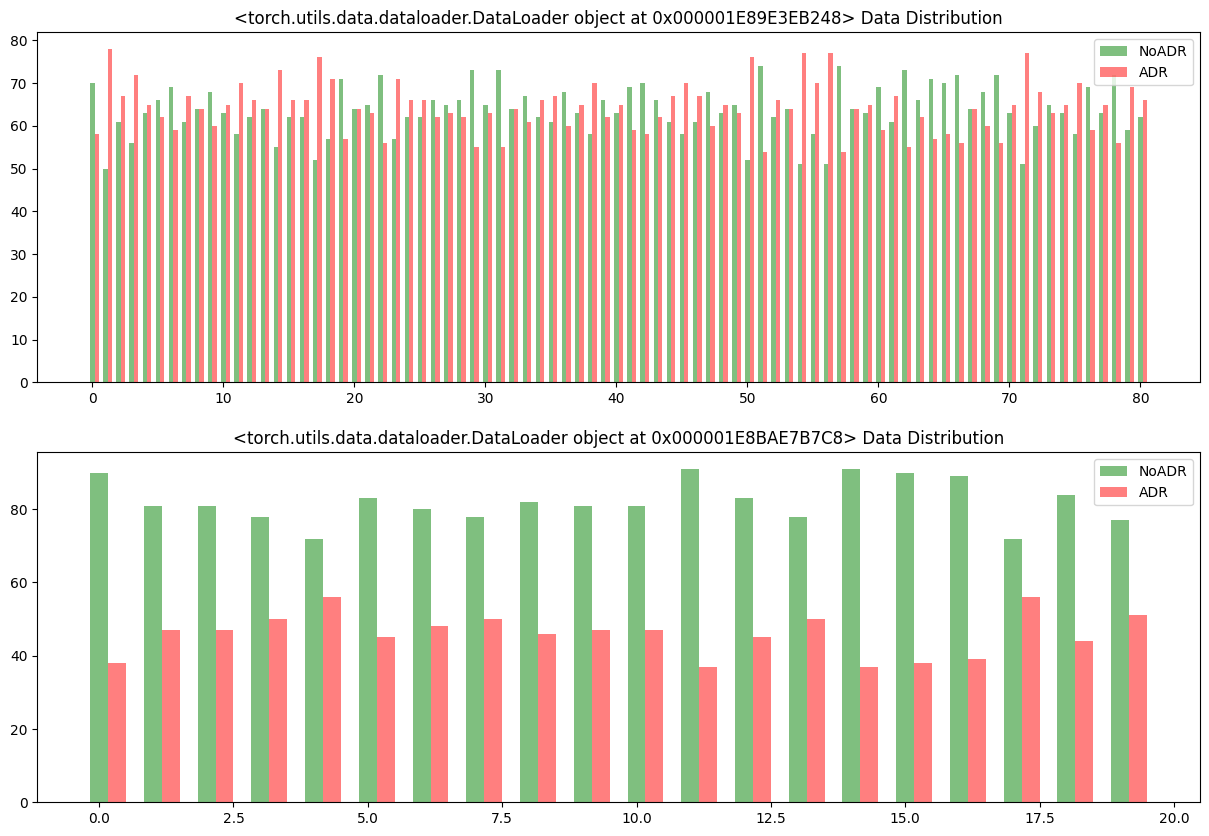

In [253]:
# Standard

# Define Hyperparameters
batch_size = 128
learning_rate = 2e-5
epochs = 1000

# Create model
model = Network().to(device)
print(model)

# Get train, test_loader and display data distribution
train_loader, test_loader = get_dataloaders(batch_size)
get_dataloader_distribution(train_loader,test_loader)

# Assign Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#,weight_decay=0.01)

# Assign Loss Function
loss_fn = nn.BCELoss()

# Assign Run Name
name = f"Model-ATTEMPTCONV1D2"
dir = os.path.join('logs_FINAL', name)
writer = SummaryWriter()
total_train_loss = []
total_test_loss = []
total_train_acc = []
total_test_acc = []

for t in range(epochs):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    test_loss, test_acc, test_precision, test_recall, test_f1 = test(test_loader, model, loss_fn)
    print(f"epoch: {t}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}, test precision: {test_precision:.4f}, test recall: {test_recall:.4f}, test f1: {test_f1:.4f}")
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)
    total_train_acc.append(train_acc)
    total_test_acc.append(test_acc)
    with tf.summary.create_file_writer(f"{dir}_train").as_default():
        tf.summary.scalar("loss", train_loss, step=t)
        tf.summary.scalar("acc", train_acc, step=t)
    with tf.summary.create_file_writer(f"{dir}_test").as_default():    
        tf.summary.scalar("loss", test_loss, step=t) 
        tf.summary.scalar("acc", test_acc, step=t)
        tf.summary.scalar("precision", test_precision, step=t)
        tf.summary.scalar("f1_score", test_f1, step=t)
        tf.summary.scalar("recall_score", test_recall, step=t)
        # trial.report(test_loss, epoch)
save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss)
save_CFmatrix(name)
save_PRAUC(name)
save_model(name,optimizer,loss_fn)

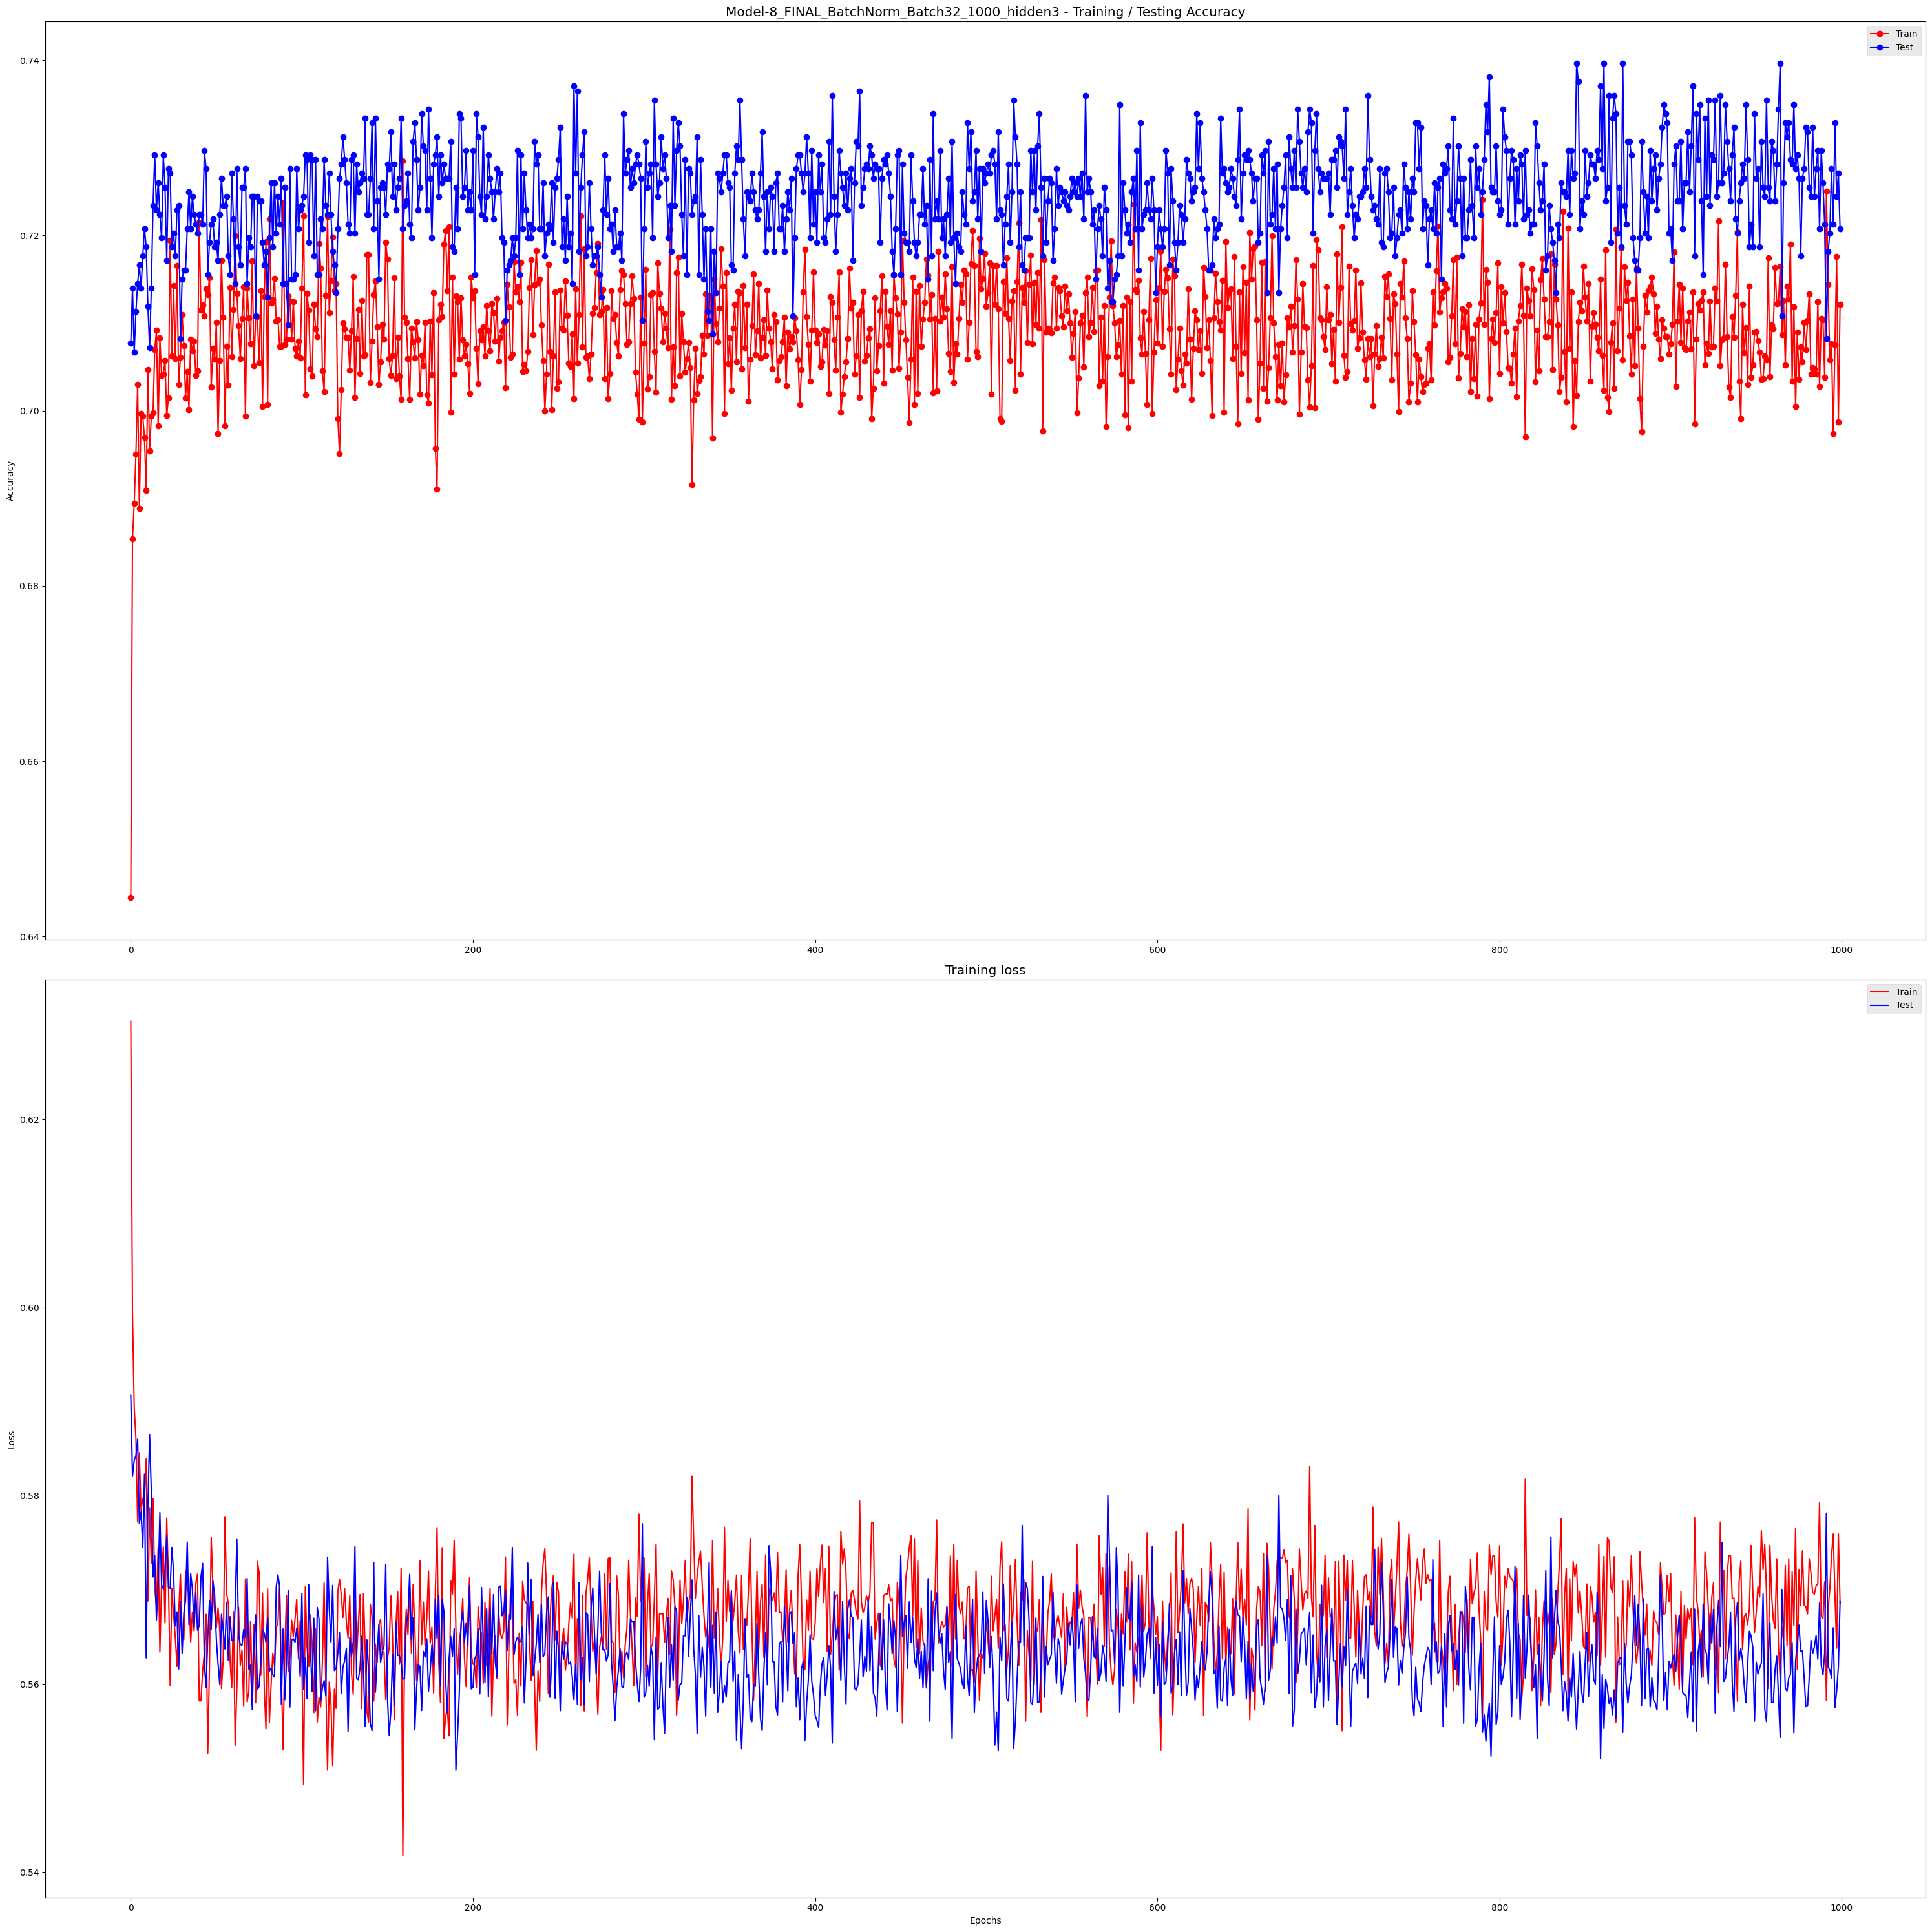

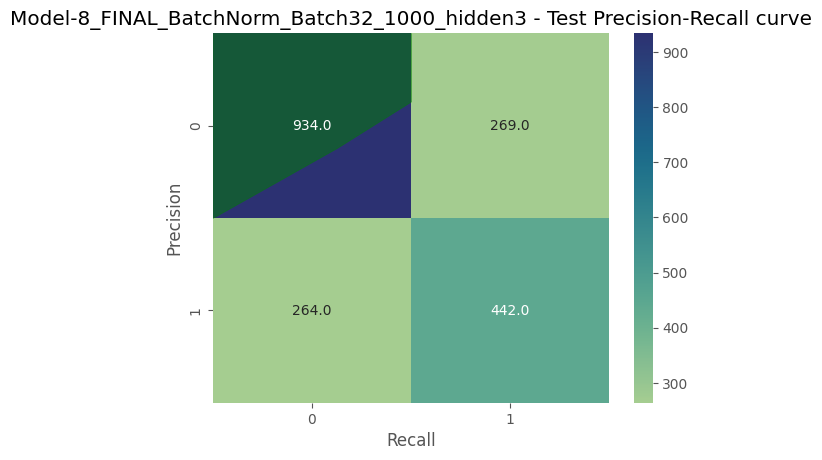

In [27]:
save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss)
save_CFmatrix(name)
save_PRAUC(name)
save_model(name,optimizer,loss_fn)

In [32]:
# Code variation for different batch sizes
for x in [16]:
    # Create model
    model = Network().to(device)
    print(model)

    # Define Hyperparameters
    batch_size = x
    learning_rate = 2e-5
    epochs = 50

    # Get train, test_loader and display data distribution
    train_loader, test_loader = get_dataloaders(batch_size)
    get_dataloader_distribution(train_loader,test_loader)

    # Assign Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.01)

    # Assign Loss Function
    loss_fn = nn.BCELoss()

    # Assign Run Name
    name = f"Model-8_FINAL(checkBATCH_{x}))"
    dir = os.path.join('logs_FINAL', name)
    writer = SummaryWriter()
    total_train_loss = []
    total_test_loss = []
    total_train_acc = []
    total_test_acc = []

    for t in range(epochs):
        train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc, test_precision, test_recall, test_f1 = test(test_loader, model, loss_fn)
        print(f"epoch: {t}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}, test precision: {test_precision:.4f}, test recall: {test_recall:.4f}, test f1: {test_f1:.4f}")
        total_train_loss.append(train_loss)
        total_test_loss.append(test_loss)
        total_train_acc.append(train_acc)
        total_test_acc.append(test_acc)
        with tf.summary.create_file_writer(f"{dir}_train").as_default():
            tf.summary.scalar("loss", train_loss, step=t)
            tf.summary.scalar("acc", train_acc, step=t)
        with tf.summary.create_file_writer(f"{dir}_test").as_default():    
            tf.summary.scalar("loss", test_loss, step=t) 
            tf.summary.scalar("acc", test_acc, step=t)
            tf.summary.scalar("precision", test_precision, step=t)
            tf.summary.scalar("f1_score", test_f1, step=t)
            tf.summary.scalar("recall_score", test_recall, step=t)
            # trial.report(test_loss, epoch)
    save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss)
    save_CFmatrix(name)
    save_PRAUC(name)
    save_model(name,optimizer,loss_fn)
    


Network(
  (layers1): Sequential(
    (0): Conv1d(16, 16, kernel_size=(5,), stride=(3,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=2067, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=

c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 577, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 312, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2067, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2103, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


In [80]:
writer.close()

# Save

In [22]:
torch.save(model.state_dict(), f'../4 - Training & Testing/models/model_{name}.pt')

In [23]:
def save_graphs(name,total_train_acc,total_test_acc,total_train_loss,total_test_loss):
    fig, ax = plt.subplots(2,1)
    plt.style.use('ggplot')
    fig.set_figheight(30)
    fig.set_figwidth(30)

    ax[0].set_title(f"{name} - Training / Testing Accuracy")
    ax[0].plot(total_train_acc, 'red',label='Train',marker='o')
    ax[0].plot(total_test_acc,'blue',label='Test',marker='o')
    #ax[0].xaxis.set(ticks=range(0,len(total_train_acc),1))
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()
    #ax[0].text(4,1,f"Model: {numberofmodel}")


    ax[1].set_title("Training / Testing loss")
    ax[1].set_xlabel("Epochs")
    ax[1].plot(total_train_loss,label = 'Train',color='red')
    ax[1].plot(total_test_loss,label = 'Test',color='blue')
    #ax[1].xaxis.set(ticks=range(0,len(total_train_loss),1))
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    #plt.show()

    plt.tight_layout()#h_pad = 3, w_pad=3)
    plt.savefig(f"../4 - Training & Testing/models/model_graph_{name}.png")

In [24]:
def save_CFmatrix(name):

    import seaborn as sns


    with torch.no_grad():
        data = test_loader.dataset.tensors[0].to(device)
        predicted = model(data).to(device)
        predicted = predicted.cpu()
        predicted = predicted.flatten()
        predicted = torch.round(predicted)
        target = test_loader.dataset.tensors[1].flatten()

    cf_matrix = confusion_matrix(target, predicted)
    fig, ax = plt.subplots()
    ax = sns.heatmap(cf_matrix, annot=True, fmt=".1f",cmap="crest")
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set(xlabel='Predicted', ylabel='Actual')
    ax_fig = ax.get_figure()
    ax_fig.savefig(f"../4 - Training & Testing/models/model_cf_{name}.png")
    # disp.plot(xticks_rotation=90)
    


In [25]:
def save_PRAUC(name):
    with torch.no_grad():
        data = test_loader.dataset.tensors[0].to(device)
        predicted = model(data).to(device)
        predicted = predicted.cpu()
        predicted = predicted.flatten()
        predicted = torch.round(predicted)
        target = test_loader.dataset.tensors[1].flatten()
    precision, recall, thresholds = precision_recall_curve(target, predicted)
    plt.fill_between(recall, precision, alpha=0.5, color='g')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title(f"{name} - Test Precision-Recall curve")
    plt.savefig(f"../4 - Training & Testing/models/model_PRAUC_{name}.png")

In [85]:
from torchsummary import summary
summary(model.cuda(),(1,1,df_input.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1, 1, 1024]       4,188,160
              ReLU-2           [-1, 1, 1, 1024]               0
           Dropout-3           [-1, 1, 1, 1024]               0
            Linear-4           [-1, 1, 1, 1024]       1,049,600
              ReLU-5           [-1, 1, 1, 1024]               0
           Dropout-6           [-1, 1, 1, 1024]               0
            Linear-7           [-1, 1, 1, 1024]       1,049,600
              ReLU-8           [-1, 1, 1, 1024]               0
           Dropout-9           [-1, 1, 1, 1024]               0
           Linear-10           [-1, 1, 1, 1024]       1,049,600
             ReLU-11           [-1, 1, 1, 1024]               0
          Dropout-12           [-1, 1, 1, 1024]               0
           Linear-13              [-1, 1, 1, 1]           1,025
          Sigmoid-14              [-1, 

In [26]:
def save_model(name,optimizer,loss_fn):
    f = open(f"../4 - Training & Testing/models/{name}.txt",'w')
    f.write(f"{str(optimizer)} \n\n{str(loss_fn)} \n\n")
    f.close()